## Bracket Challenge Predictor

Reading data

In [220]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns

from functools import reduce
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

from xgboost import XGBRegressor

In [215]:
team_matchups = pd.read_csv("/Users/nicholaskim/Documents/Repositories/bracket challenge/data/Tournament Matchups.csv")

away_stats = pd.read_csv("/Users/nicholaskim/Documents/Repositories/bracket challenge/data/Barttorvik Away.csv")
home_stats = pd.read_csv("/Users/nicholaskim/Documents/Repositories/bracket challenge/data/Barttorvik Home.csv")
neutral_stats = pd.read_csv("/Users/nicholaskim/Documents/Repositories/bracket challenge/data/Barttorvik Neutral.csv")
conf_perf = pd.read_csv("/Users/nicholaskim/Documents/Repositories/bracket challenge/data/Conference Stats.csv")
team_res = pd.read_csv("/Users/nicholaskim/Documents/Repositories/bracket challenge/data/Team Results.csv")
team_v_ranked = pd.read_csv("/Users/nicholaskim/Documents/Repositories/bracket challenge/data/TeamRankings.csv")

ken_eff = pd.read_csv("/Users/nicholaskim/Documents/Repositories/bracket challenge/data/INT _ KenPom _ Efficiency.csv")
ken_height = pd.read_csv("/Users/nicholaskim/Documents/Repositories/bracket challenge/data/INT _ KenPom _ Height.csv")
ken_conf = pd.read_csv("/Users/nicholaskim/Documents/Repositories/bracket challenge/data/DEV _ March Madness.csv")

conf_mapping = pd.read_csv("/Users/nicholaskim/Documents/Repositories/bracket challenge/data/REF _ NCAAM Conference and ESPN Team Name Mapping.csv")

cur_coaches = pd.read_csv("/Users/nicholaskim/Documents/Repositories/bracket challenge/data/REF _ Current NCAAM Coaches.csv")
coach_perf = pd.read_csv("/Users/nicholaskim/Documents/Repositories/bracket challenge/data/Coach Results.csv")

seed_res = pd.read_csv("/Users/nicholaskim/Documents/Repositories/bracket challenge/data/Seed Results.csv")
upset_count = pd.read_csv("/Users/nicholaskim/Documents/Repositories/bracket challenge/data/Upset Count.csv")
upset_inf = pd.read_csv("/Users/nicholaskim/Documents/Repositories/bracket challenge/data/Upset Seed Info.csv")

/var/folders/g4/t1q9yqqx7h36p5_2jzq23jsw0000gn/T/ipykernel_28025/4147926393.py:12: DtypeWarning: Columns (144) have mixed types. Specify dtype option on import or set low_memory=False.
  ken_conf = pd.read_csv("/Users/nicholaskim/Documents/Repositories/bracket challenge/data/DEV _ March Madness.csv")


since ken_ datasets don't have TEAMNO var will first create seperate lookup table to create a column for its respective id

In [216]:
team_ids = team_matchups[['YEAR','TEAM','TEAM NO']].drop_duplicates()
conf_ids = conf_perf[['YEAR','CONF','CONF ID']].drop_duplicates()

team_res.rename(columns={'TEAM ID':'TEAM NO'},inplace=True)

ken_eff.rename(columns={'Season':'YEAR','Team':'TEAM'},inplace=True)
ken_height.rename(columns={'Season':'YEAR','TeamName':'TEAM'},inplace=True)
ken_conf.rename(columns={'Season':'YEAR','Short Conference Name':'CONF'},inplace=True)

ken_eff = ken_eff.merge(team_ids,on=['YEAR','TEAM'],how='left')
ken_height = ken_height.merge(team_ids,on=['YEAR','TEAM'],how='left')
ken_conf = ken_conf.merge(conf_ids,on=['YEAR','CONF'],how='left')

In [263]:
sos = [away_stats.loc[:,['YEAR','TEAM NO','ELITE SOS']],home_stats.loc[:,['YEAR','TEAM NO','ELITE SOS']],neutral_stats.loc[:,['YEAR','TEAM NO','ELITE SOS']]]
sos = reduce(lambda left, right: pd.merge(left, right, on=['YEAR','TEAM NO']),sos)

sos['ELITE SOS'] = sos[['ELITE SOS_x','ELITE SOS_y','ELITE SOS']].mean(axis=1)
sos.head()

,YEAR,TEAM NO,ELITE SOS_x,ELITE SOS_y,ELITE SOS
0,2024,1079,15.936,4.788,12.487667
1,2024,1078,54.469,21.044,40.656667
2,2024,1077,42.102,15.826,34.386000
3,2024,1076,44.169,16.187,30.635667
4,2024,1075,51.232,25.070,42.132000


In [ ]:
temp_away = away_stats.loc[:,['YEAR','TEAM NO','BADJ O','BADJ D','WIN%','EFG%','EFG%D','PPPO','PPPD']]
temp_home = home_stats.loc[:,['YEAR','TEAM NO','BADJ O','BADJ D','WIN%','EFG%','EFG%D','PPPO','PPPD']]
temp_neutral = neutral_stats.loc[:,['YEAR','TEAM NO','BADJ O','BADJ D','WIN%','EFG%','EFG%D','PPPO','PPPD']]

neutral_stats.loc[:,['YEAR','TEAM NO','BADJ EM','FTR','FTRD',
                'BADJ T','TOV%','TOV%D','OREB%','OP OREB%','RAW T','WAB',
                '2PT%', '2PT%D', '3PT%', '3PT%D', 'BLK%', 'BLKED%',
                'AST%', 'OP AST%', '2PTR', '3PTR', '2PTRD', '3PTRD']]

#adds _A to all columns to represent Away
temp_away.columns = list(temp_away.columns[:2]) + [col + "_A" for col in temp_away.columns[2:]]

#_H for Home
temp_home.columns = list(temp_home.columns[:2]) + [col + "_H" for col in temp_home.columns[2:]]

#_N for Neutral
temp_neutral.columns = list(temp_neutral.columns[:2]) + [col + "_N" for col in temp_neutral.columns[2:]]

temp_res = team_res.loc[:,['TEAM','PAKE','PASE','R64','R32','S16','E8','F4',
                           'F2','CHAMP','TOP2']]

temp_v_ranked = team_v_ranked.loc[:,['YEAR','TEAM NO','TR RATING','V 1-25 WINS','V 1-25 LOSS',
                                     'V 26-50 WINS','V 26-50 LOSS','LUCK RATING','CONSISTENCY TR RATING']]

temp_ken_eff = ken_eff.loc[:,['YEAR','TEAM NO','Adjusted Offensive Efficiency','Adjusted Defensive Efficiency',
                              'Avg Possession Length (Offense)','Avg Possession Length (Defense)']]

temp_height = ken_height.loc[:,['YEAR','TEAM NO','AvgHeight','EffectiveHeight','Experience','Bench']]


Creating supplmental dataset that aren't dependent on team metrics (i.e: conference, coach, upsets)

Created a column on who won each matchup for every game in the dataset. Will now add columns of interest to this dataset and will try to do feature engineering as to model who'd win each matchup.

In [218]:
wins = []
for i in range(len(team_matchups)//2):
    if team_matchups.iloc[i,8] > team_matchups.iloc[i+1,8]:
        wins.append(1)
        wins.append(0)
    else:
        wins.append(0)
        wins.append(1)
    i += 2

comp_stats = team_matchups.iloc[:,[0,3,4,5,6,7,8]]
comp_stats['WIN'] = wins
        
comp_stats.head()

/var/folders/g4/t1q9yqqx7h36p5_2jzq23jsw0000gn/T/ipykernel_28025/1098123238.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_stats['WIN'] = wins


,YEAR,TEAM NO,TEAM,SEED,ROUND,CURRENT ROUND,SCORE,WIN
0,2024,1067,Connecticut,1,1,64,91,1
1,2024,1026,Stetson,16,64,64,52,0
2,2024,1060,Florida Atlantic,8,64,64,65,0
3,2024,1036,Northwestern,9,32,64,77,1
4,2024,1029,San Diego St.,5,16,64,69,0


In [219]:
dfs = [comp_stats,temp_away,temp_home,temp_neutral,temp_v_ranked,temp_height,temp_ken_eff]

comp_team_stats = reduce(lambda left, right: pd.merge(left, right, on=['YEAR','TEAM NO']),dfs)

comp_team_stats = comp_team_stats.merge(temp_res,on='TEAM',how='left')

comp_team_stats.head()

,YEAR,TEAM NO,TEAM,SEED,ROUND,CURRENT ROUND,SCORE,WIN,BADJ EM_A,BADJ O_A,BADJ D_A,WIN%_A,EFG%_A,EFG%D_A,FTR_A,FTRD_A,BADJ T_A,TOV%_A,TOV%D_A,OREB%_A,OP OREB%_A,RAW T_A,PPPO_A,PPPD_A,ELITE SOS_A,WAB_A,2PT%_A,2PT%D_A,3PT%_A,3PT%D_A,BLK%_A,BLKED%_A,AST%_A,OP AST%_A,2PTR_A,3PTR_A,2PTRD_A,3PTRD_A,BADJ EM_H,BADJ O_H,BADJ D_H,WIN%_H,EFG%_H,EFG%D_H,FTR_H,FTRD_H,BADJ T_H,TOV%_H,TOV%D_H,OREB%_H,OP OREB%_H,RAW T_H,PPPO_H,PPPD_H,ELITE SOS_H,WAB_H,2PT%_H,2PT%D_H,3PT%_H,3PT%D_H,BLK%_H,BLKED%_H,AST%_H,OP AST%_H,2PTR_H,3PTR_H,2PTRD_H,3PTRD_H,BADJ EM_N,BADJ O_N,BADJ D_N,WIN%_N,EFG%_N,EFG%D_N,FTR_N,FTRD_N,BADJ T_N,TOV%_N,TOV%D_N,OREB%_N,OP OREB%_N,RAW T_N,PPPO_N,PPPD_N,ELITE SOS_N,WAB_N,2PT%_N,2PT%D_N,3PT%_N,3PT%D_N,BLK%_N,BLKED%_N,AST%_N,OP AST%_N,2PTR_N,3PTR_N,2PTRD_N,3PTRD_N,TR RATING,V 1-25 WINS,V 1-25 LOSS,V 26-50 WINS,V 26-50 LOSS,LUCK RATING,CONSISTENCY TR RATING,AvgHeight,EffectiveHeight,Experience,Bench,Adjusted Offensive Efficiency,Adjusted Defensive Efficiency,Avg Possession Length (Offense),Avg Possession Length (Defense),PAKE,PASE,R64,R32,S16,E8,F4,F2,CHAMP,TOP2
0,2024,1067,Connecticut,1,1,64,91,1,27.8,129.5,101.7,75.000000,56.6,50.6,30.9,34.8,64.3,16.0,15.6,36.1,31.5,64.6,1.206,1.109,50.808,4.30,54.5,46.9,39.6,38.7,12.9,11.1,61.6,51.5,59.2,40.8,66.6,33.4,34.3,123.7,89.4,100.000000,57.5,41.4,35.9,31.0,66.6,14.5,17.6,38.9,25.7,67.1,1.261,0.881,15.790,3.5,59.9,40.8,36.1,28.3,16.1,7.0,62.1,39.8,58.5,41.5,65.5,34.5,38.2,126.7,88.5,100.000000,57.0,44.2,31.0,32.0,65.4,13.7,13.4,30.6,21.1,67.1,1.195,0.954,46.924,3.50,62.4,45.1,32.4,28.0,11.9,6.6,71.9,49.3,60.5,39.5,70.9,29.1,22.3,10,2,4,0,2.4,10.8,78.42,1.53,2.43106,28.14,127.5,91.1,18.6,17.5,10.8,13.3,10,6,5,5,5,4,4,2
1,2024,1026,Stetson,16,64,64,52,0,-9.4,106.0,115.4,37.500000,49.9,54.9,29.6,26.5,66.8,16.6,13.8,26.5,30.8,66.5,1.047,1.152,21.142,-5.70,48.5,54.3,34.5,37.2,6.8,8.7,48.6,56.2,57.5,42.5,61.3,38.7,-3.4,110.0,113.4,84.615385,56.6,50.2,36.3,27.1,67.8,14.6,13.5,27.7,30.7,67.7,1.171,1.097,3.425,-1.3,55.8,50.8,38.6,32.7,8.7,6.9,46.6,41.2,59.2,40.8,65.7,34.3,11.9,120.9,109.0,100.000000,61.5,42.5,18.6,14.2,62.2,17.7,10.4,35.7,36.4,62.3,1.253,1.028,4.875,0.16,63.1,45.8,39.6,25.8,8.3,10.8,61.7,46.9,57.5,42.5,53.7,46.3,-2.0,0,1,0,1,2.7,12.7,77.68,1.34,1.78601,22.03,109.8,114.3,18.4,17.5,0.0,0.0,1,0,0,0,0,0,0,0
2,2024,1060,Florida Atlantic,8,64,64,65,0,5.9,114.1,108.2,50.000000,51.7,52.3,33.1,29.6,68.6,15.4,15.1,34.4,30.4,68.2,1.144,1.111,24.527,-1.60,51.6,52.2,34.6,35.0,6.5,9.1,50.0,43.7,61.1,38.9,64.9,35.1,16.5,118.1,101.6,92.857143,56.5,47.2,33.4,23.7,68.1,15.1,16.3,36.1,27.9,68.9,1.213,0.987,8.393,0.8,57.6,47.9,36.6,30.7,9.1,5.6,53.9,32.7,60.0,40.0,61.1,38.9,23.0,120.9,97.9,77.777778,56.6,50.6,39.0,31.2,70.5,17.4,18.2,29.0,30.2,70.2,1.147,1.045,34.629,2.00,58.7,48.1,35.2,37.2,7.2,5.7,47.5,38.8,63.2,36.8,66.4,33.6,12.7,1,1,1,0,-0.1,9.9,76.55,-0.32,2.57785,32.11,117.8,102.1,16.5,18.3,2.8,2.7,2,1,1,1,1,0,0,0
3,2024,1036,Northwestern,9,32,64,77,1,14.5,112.4,97.9,36.363636,49.5,51.8,30.2,45.9,64.4,16.3,17.1,23.4,29.9,64.5,1.027,1.088,49.766,-0.42,45.5,53.7,37.1,32.2,9.2,10.8,54.1,60.1,60.6,39.4,65.6,34.4,17.8,121.5,103.7,88.235294,56.6,52.3,32.1,35.7,65.0,10.8,19.7,26.9,28.1,64.9,1.212,1.050,19.024,2.4,52.9,49.4,42.3,38.2,9.8,10.4,63.9,59.5,65.2,34.8,62.3,37.7,20.0,107.6,87.6,50.000000,48.3,48.0,19.9,37.3,63.9,16.1,19.2,27.5,23.7,63.8,0.999,0.952,29.248,-0.47,46.1,44.2,34.4,35.8,12.5,8.5,52.1,50.0,61.0,39.0,59.7,40.3,11.7,3,5,3,3,1.5,10.6,77.59,0.43,2.51412,24.66,115.9,99.5,18.9,18.1,0.9,0.8,3,3,0,0,0,0,0,0
4,2024,1029,San Diego St.,5,16,64,69,0,14.6,110.8,96.2,42.857143,48.1,49.4,29.7,40.1,66.3,15.9,17.1,32.9,28.0,65.7,1.051,1.044,41.955,-0.70,48.8,49.0,31.3,33.3,10.6,11.2,46.3,51.8,61.8,38.2,58.9,41.1,19.4,110.1,90.7,92.307692,52.4,46.2,41.2,26.5,68.6,18.1,20.4,32.6,25.5,68.8,1.095,0.911,15.353,1.9,56.6,47.7,30.7,29.2,12.7,7.0,53.4,43.8,60.5,39.5,59.5,40.5,22.0,119.3,97.3,80.000000,48.0,44.5,50.0,32.8,65.2,10.6,14.1,32.4,33.3,66.2,1.155,1.023,36.909,1.40,47.5,47.7,32.7,26.4,13.3,7.4,56.

Checking multicollinerity between Away, Home, and Neutral team stats

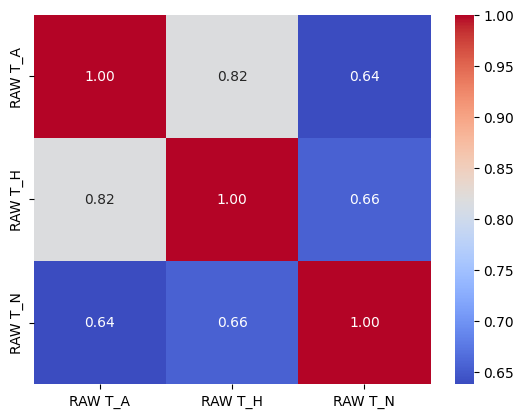

In [262]:
corr_matrix = comp_team_stats[['RAW T_A','RAW T_H','RAW T_N']].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

In [252]:
import numpy as np
import pandas as pd

# Define threshold for strong correlation (e.g., 0.8)
threshold = 0.2

# Find pairs of highly correlated features
below_thres_corr_pairs = [
    (col1, col2, corr_matrix.loc[col1, col2])
    for col1 in corr_matrix.columns
    for col2 in corr_matrix.columns
    if col1 != col2 and abs(corr_matrix.loc[col1, col2]) < threshold
]

# Convert to DataFrame for better visualization
below_thres_corr_df = pd.DataFrame(below_thres_corr_pairs, columns=["Feature1", "Feature2", "Correlation"])
below_thres_corr_df = below_thres_corr_df.sort_values(by="Correlation", ascending=False)

below_thres_corr_df



,Feature1,Feature2,Correlation
1101,WAB_A,3PT%_A,0.199378
1282,3PT%_A,WAB_A,0.199378
586,TOV%_A,TOV%D_H,0.198803
2632,TOV%D_H,TOV%_A,0.198803
1245,2PT%D_A,3PTR_H,0.198798
...,...,...,...
4513,FTRD_N,EFG%_N,-0.199493
4024,BADJ EM_N,TOV%_H,-0.199693
2604,TOV%_H,BADJ EM_N,-0.199693
4747,TOV%D_N,PPPO_N,-0.199717


Due to prescense of strong multicollinerity we'll use the neutral site game statistics as our basis with the expection of a couple (like WIN%) to capture so essential information on a teams performance at all these locations. In addition, some statistics we'll combine (like ELITE SOS)